In [578]:
import numpy
numpy.seterr(divide='warn')
import pandas
from tkinter import Tk
from tkinter.filedialog import askdirectory
import seaborn

In [583]:
# Get directories for IMU data
forearmPath = "/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/IMU Analysis/ForeArmReal20221111"#askdirectory(title='Select Folder Containing Forearm Data') # shows dialog box and return the path
print(forearmPath)
armPath = "/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/IMU Analysis/ArmReal20221111"#askdirectory(title='Select Folder Containing Arm Data') # shows dialog box and return the path
print(armPath)
foreArmGData = pandas.read_csv("{}/Gyroscope.csv".format(forearmPath))
armGData = pandas.read_csv("{}/Gyroscope.csv".format(armPath))
# Truncate data to have same number of samples (temporary with contrived data)
minDataLength = min(len(armGData), len(foreArmGData))
foreArmGData = foreArmGData[:minDataLength]
armGData = armGData[:minDataLength]
# Initialize gyroscope data array(g1, g2) (2 arrays with # rows equal to # sample and each row [x, y, z])
gDataRaw = numpy.array([numpy.stack([foreArmGData['X (rad/s)'].values, foreArmGData['Y (rad/s)'].values, foreArmGData['Z (rad/s)'].values], 1),\
                    numpy.stack([armGData['X (rad/s)'].values, armGData['Y (rad/s)'].values, armGData['Z (rad/s)'].values], 1)])
# Number of samples a second to resample data at and valiue in Hz
reSamples = 15.0
reSampleRate = 1.0/reSamples
# Calculate new time vectors with sample grouping between samples in seconds
timeVFore = numpy.floor((foreArmGData['Time (s)'].values/reSampleRate))
timeVArm = numpy.floor((armGData['Time (s)'].values/reSampleRate))
#create new data arrays with same timebase
gFore = []
for i in range(numpy.int(numpy.max(timeVFore))):
    newRow = numpy.mean(gDataRaw[0][numpy.where(timeVFore == i)], axis=0)
    gFore.append(list(newRow))
gFore = numpy.array(gFore)
gArm = []
for i in range(numpy.int(numpy.max(timeVArm))):
    newRow = numpy.mean(gDataRaw[0][numpy.where(timeVFore == i)], axis=0)
    gArm.append(numpy.array(newRow))
gArm = numpy.array(gArm)
gData = numpy.array([numpy.array(gFore), numpy.array(gArm)])

/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/IMU Analysis/ForeArmReal20221111
/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/IMU Analysis/ArmReal20221111


/var/folders/6b/1zwtp83s1b93_8j_qjyxh2b00000gn/T/ipykernel_32690/2674616550.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for i in range(numpy.int(numpy.max(timeVFore))):
/var/folders/6b/1zwtp83s1b93_8j_qjyxh2b00000gn/T/ipykernel_32690/2674616550.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to re

In [580]:
# Calculate time delta between samples in seconds
deltat = numpy.average(numpy.diff(foreArmGData['Time (s)'].values))
# Calculate angle moved for each time step by integrating gyroscope data over time
angleSteps = gData * deltat
angleData = numpy.cumsum(angleSteps, axis=1)
degreeData = numpy.rad2deg(angleData)
seaborn.set(style="darkgrid")
a = seaborn.lineplot(data=degreeData[0])

AxisError: axis 1 is out of bounds for array of dimension 1

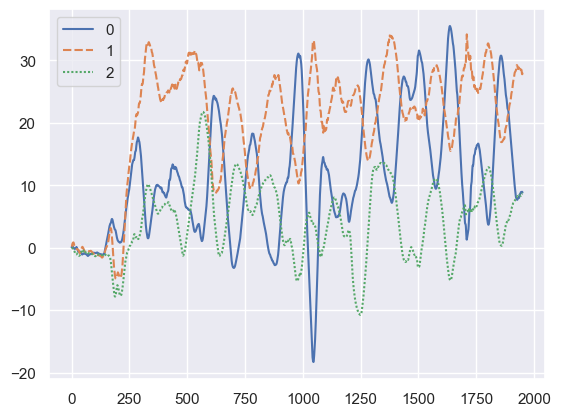

In [ ]:

b = seaborn.lineplot(data=degreeData[1])

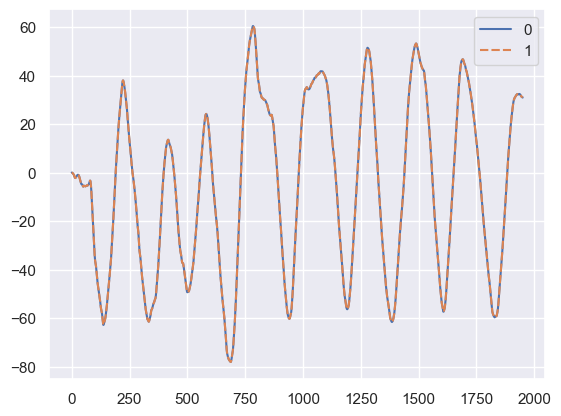

In [ ]:
def getJEst(aEst):
    j1Est = numpy.array([numpy.cos(aEst[0][1])*numpy.cos(aEst[0][2]), numpy.cos(aEst[0][1])*numpy.sin(aEst[0][2]), numpy.sin(aEst[0][1])])
    j2Est = numpy.array([numpy.cos(aEst[1][1])*numpy.cos(aEst[1][2]), numpy.cos(aEst[1][1])*numpy.sin(aEst[1][2]), numpy.sin(aEst[1][1])])
    return numpy.array([j1Est, j2Est])


# Vector of angle and azimuth values for such that theta unit vector is parallel to x axis, perp to z and y (x axis is hinge axis)
aaVec = numpy.array([[1, 0, 0], [1, 0, 0.1]])
jEst = getJEst(aaVec)
aRates = numpy.dot(gData[0], jEst[0])
aAngles = aRates * deltat
aData = numpy.cumsum(aAngles)
degreeAData = numpy.rad2deg(aData)
a = seaborn.lineplot(data=[degreeAData, degreeData[0].T[0]])


In [ ]:
def getGJacobian(j, g):

    numerator1 = numpy.cross(numpy.cross(g[0], j[0]), g[0])
    denominator1 = numpy.linalg.norm(numpy.cross(g[0], j[0]), axis=1)
    grad1 = numpy.divide(numerator1.T, denominator1).T
    numerator2 = numpy.cross(numpy.cross(g[1], j[1]), g[1])
    denominator2 = numpy.linalg.norm(numpy.cross(g[1], j[1]), axis=1)
    grad2 = numpy.divide(numerator2.T, denominator2).T
    
    return(numpy.array([grad1, grad2]))

def getGErrorVector(j, g):
    left = numpy.linalg.norm(numpy.cross(j[0], g[0]), axis=1)
    right = numpy.linalg.norm(numpy.cross(j[1], g[1]), axis=1)
    errs = left - right
    return(errs)
    
# Get error vector
for _ in range(30):
    gErrors = getGErrorVector(jEst, gData)
    print(numpy.sum(gErrors**2))
    # print(jEst)
    #Calculate Jacobian
    gJacobian = getGJacobian(jEst, gData)
    # Calculate pseudoinverce
    gPseudoinverse = numpy.linalg.pinv(gJacobian)
    a = numpy.dot(gPseudoinverse, gErrors)
    # inv = numpy.matmul(numpy.linalg.inv(numpy.matmul(gJacobian.T, gJacobian)), gJacobian.T)
    aaVec = aaVec - a
    jEst = getJEst(aaVec)


199.38895685190317
191.48378042603463
191.9439728013853
196.96296717730326
208.56987056834703
229.0231907133009
257.13285629678603
279.3099345690317
289.94003830699427
316.36967078810187
375.0694758261448
579.2160118990232
1144.3193696637168
1784.8404982103707
1887.0335884815877
1890.3484911049507
1867.04841034412
1848.851355971205
1873.9910439690277
1858.4332019262015
1819.0417120895177
1869.6955637907115
1878.351302147153
1797.1419470314686
1714.5585036833118
1663.3171293523537
1811.8462537633786
1801.5251754174092
1844.8837553640917
1879.1796897083243


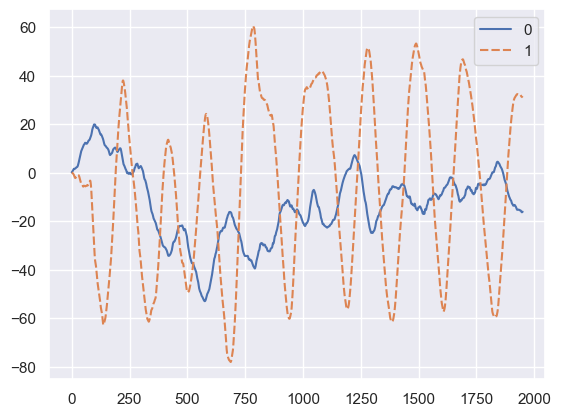

In [ ]:

aRates1 = numpy.dot(gData[0], jEst[0])
aRates2 = numpy.dot(gData[1], jEst[1])
aAngles = (aRates1-aRates2) * deltat
aData = numpy.cumsum(aAngles)
degreeAData = numpy.rad2deg(aData)
a = seaborn.lineplot(data=[degreeAData, degreeData[0].T[0]])